Import libraries

In [38]:
#import libraries
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

Import processed photometry file and plot the corrected Z-scored trace.  This should have columns "TimeStampAdjusted" and "Fluorescence_Corrected_Z'. See related notebook "Photometry_preprocessing" for this step.




In [39]:
# Prompt user to upload a CSV file
print("Please upload a CSV file.")
uploaded = files.upload()

# Load the uploaded CSV file into a DataFrame and adjust TimeStamp column
if uploaded:
    filename = next(iter(uploaded))
    dfraw = pd.read_csv(filename)
    print("Uploaded file successfully loaded into DataFrame 'dfraw'.")

else:
    print("No file uploaded.")

Please upload a CSV file.


Saving Fluorescence_processed.csv to Fluorescence_processed (2).csv
Uploaded file successfully loaded into DataFrame 'dfraw'.


Plot the z-scored fluorescence trace to take a look at it

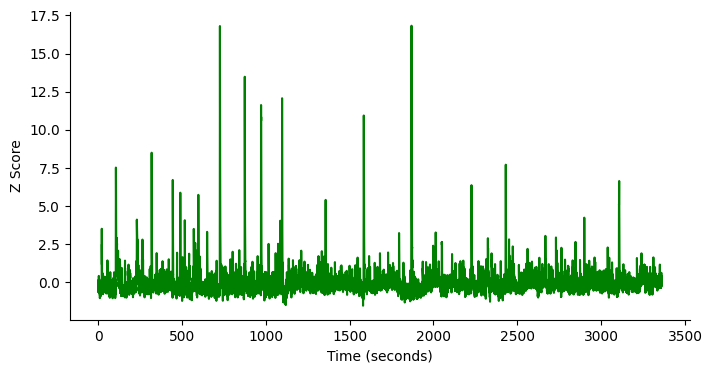

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))  # Unpack the returned figure and axes objects
ax.plot(dfraw['TimeStampAdjusted'], dfraw['Fluorescence_Corrected_Z'], label='Fluorescence Corrected', color = "g")
ax.set_xlabel('Time (seconds)')  # Set x-axis label
ax.set_ylabel('Z Score')  # Set y-axis label

# Remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


Identify all relevant event timestamps (based on "Input2*2*0" from RWD system and plot PSTH.  If your timestamps are labeled differently you can modify this cell to store relevant timepoints in a list called "timestamps"

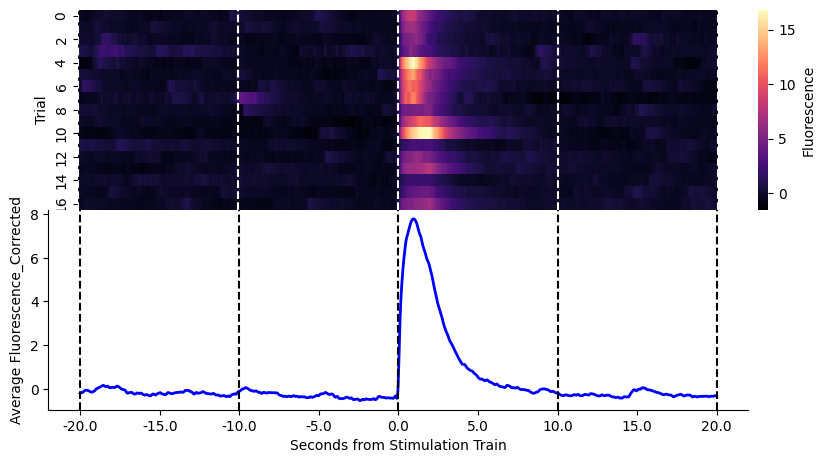

In [42]:
#create a new copy to work with (we can go back to this step if we need to without re-importing the .csv file)
df = dfraw.copy()

# Identify the timestamps for 'attenuator_1sec20Hz' and 'noattenuator_1sec20Hz'
timestamps = []
empty_count = 0
for index, event in df['Events'].items():
    if pd.isnull(event):
        empty_count += 1
    else:
        if "Input2*2*0" in event and empty_count >= 10:
            timestamps.append(df.loc[index, 'TimeStampAdjusted'])
        empty_count = 0

# Reset the list to store slices from the "Fluorescence_Corrected" column
Fluorescence_corrected_slices = []

# Loop through each timestamp, extract slices, and append to the list
for timestamp in timestamps:
    # Find the index of the row closest to the timestamp
    event_index = df.index[df['TimeStampAdjusted'] == timestamp].tolist()[0]

    # Define the start and end indices for slicing
    start_index = max(event_index - 1000, 0)  # Ensure the start index is not negative
    end_index = min(event_index + 1001, len(df))  # Ensure the end index does not exceed the dataframe length

    # Extract the slice from the "Fluorescence_Corrected" column and append to the list
    Fluorescence_corrected_slice = df.loc[start_index:end_index, 'Fluorescence_Corrected_Z'].to_numpy()
    # Pad slices if they are shorter than 2001 elements to ensure uniform size
    if len(Fluorescence_corrected_slice) < 2001:
        pad_size = 2001 - len(Fluorescence_corrected_slice)
        Fluorescence_corrected_slice = np.pad(Fluorescence_corrected_slice, (0, pad_size), 'constant', constant_values=(np.nan,))
    Fluorescence_corrected_slices.append(Fluorescence_corrected_slice)

# Convert the list of slices into a 2D numpy array
Fluorescence_corrected_matrix = np.array(Fluorescence_corrected_slices)

# Recalculate the row offsets to match the dimensions of the averaged data
row_offsets_corrected = np.linspace(-1000/50, 1000/50, Fluorescence_corrected_matrix.shape[1])

# Recreate the figure with corrected dimensions
fig = plt.figure(figsize=(10, 10))

# Add the heatmap subplot
ax_heatmap = fig.add_axes([0.12, 0.3, 0.8, 0.2])  # left, bottom, width, height
sns.heatmap(Fluorescence_corrected_matrix, cmap="magma", cbar_kws={'label': 'Fluorescence'}, ax=ax_heatmap)
ax_heatmap.set_xlabel('')
ax_heatmap.set_ylabel('Trial')
ax_heatmap.set_xticks(np.linspace(0, Fluorescence_corrected_matrix.shape[1], 9))
ax_heatmap.set_xticklabels("")
ax_heatmap.grid(False)  # Remove grid lines

# Add vertical lines at specified times for the heatmap
for time in [-20, -10, 0, 10, 20]:
    ax_heatmap.axvline(x=(time + 20) * (Fluorescence_corrected_matrix.shape[1] / 40), color='white', linestyle='--')

# Add the line plot subplot with a narrower width
ax_line = fig.add_axes([0.09, 0.1, 0.7, 0.2])  # left, bottom, width, height
ax_line.plot(np.nanmean(Fluorescence_corrected_matrix, axis=0), color='blue', lw=2)
ax_line.set_xlabel('Seconds from Stimulation Train')
ax_line.set_ylabel('Average Fluorescence_Corrected')
ax_line.set_xticks(np.linspace(0, Fluorescence_corrected_matrix.shape[1], 9))
ax_line.set_xticklabels(np.round(np.linspace(-20, 20, 9), 2))
ax_line.grid(False)  # Remove grid lines
ax_line.spines['right'].set_visible(False)
ax_line.spines['top'].set_visible(False)

# Add vertical lines at specified times for the line plot
for time in [-20, -10, 0, 10, 20]:
    ax_line.axvline(x=(time + 20) * (Fluorescence_corrected_matrix.shape[1] / 40), color='black', linestyle='--')

plt.show()


Extract events corresponding to different stimulation types - this is an example from an experiment in the Creed lab, you will likely want to update the event positions and names

In [43]:
#enter Number of Attenuator and NoAttenuator pulses
Number_Of_Attenuator_Pulses = 4
Number_Of_NoAttenuator_Pulses = 4

attenuator_1sec20Hz = timestamps[:Number_Of_Attenuator_Pulses]
noattenuator_1sec20Hz = timestamps[Number_Of_Attenuator_Pulses:Number_Of_Attenuator_Pulses + Number_Of_NoAttenuator_Pulses]

# Extract timestamps for the 10Hz, 20Hz, and 40Hz groups
TotalPulses = len(timestamps)
attenPulses = Number_Of_Attenuator_Pulses + Number_Of_NoAttenuator_Pulses

timestamps_10Hz = [timestamps[attenPulses], timestamps[attenPulses+3], timestamps[attenPulses+6]]
timestamps_20Hz = [timestamps[attenPulses+1], timestamps[attenPulses+4], timestamps[attenPulses+7]]
timestamps_40Hz = [timestamps[attenPulses+2], timestamps[attenPulses+5], timestamps[attenPulses+8]]

This cell uses a function "plotPSTH" for comparing specific events. This function will take a df as the first argument, followed by flexible number of arguments containing lists of events.  It also has the arguments "bar", "legend_names" and "colormap" to customize the plot.<br>

It has an argument "download" which you can set to True to have the function download a vector PDF of the output graph.


```
plotPSTH(df, list1, list2, bar=[0, 1], legend_names=['list1', 'list2'], colormap="colormap", download = True)

example:
plotPSTH(df, attenuator_1sec20Hz, noattenuator_1sec20Hz, bar=[0, 1], legend_names=['attenuator', 'no attenuator'], colormap='magma', download = True)

```




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

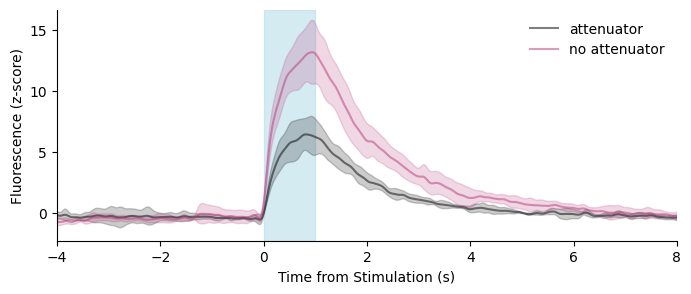

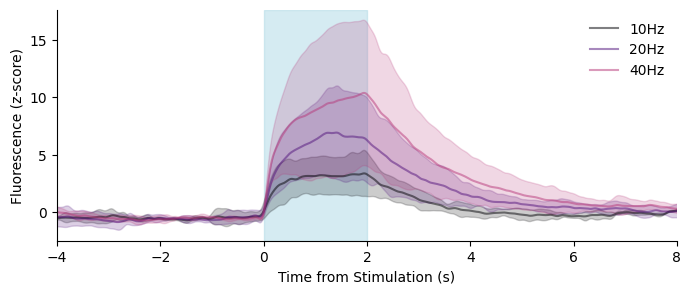

In [44]:
def extract_window_by_index(index, df, timestamps, window_size=500):
    if 0 <= index < len(timestamps):
        timestamp = timestamps[index]
        matched_indices = df.index[df['TimeStampAdjusted'] == timestamp].tolist()
        if matched_indices:
            closest_index = matched_indices[0]
            start_index = max(0, closest_index - window_size)
            end_index = min(len(df), closest_index + window_size)
            window_df = df.iloc[start_index:end_index].copy()
            window_df['RelativeIndex'] = range(-closest_index + start_index, end_index - closest_index)
            return window_df

def plotPSTH(df, *timestamps_lists, window_size=500, bar=None, legend_names=None, colormap='magma', download = True):
    plt.figure(figsize=(8, 3))

    if bar:
        plt.axvspan(bar[0], bar[1], color='lightblue', alpha=0.5)  # Set bar color to light blue

    colors = plt.get_cmap(colormap)(np.linspace(0, 0.5, len(timestamps_lists)))

    for i, timestamps in enumerate(timestamps_lists):
        all_windows = pd.DataFrame()

        for index in range(len(timestamps)):
            window_df = extract_window_by_index(index, df, timestamps, window_size)
            if window_df is not None:
                all_windows = pd.concat([all_windows, window_df], ignore_index=True)

        mean_ci_df = all_windows.groupby('RelativeIndex')['Fluorescence_Corrected_Z'].agg(['mean', 'sem'])
        mean_ci_df['ci95_lo'] = mean_ci_df['mean'] - 1.96 * mean_ci_df['sem']
        mean_ci_df['ci95_hi'] = mean_ci_df['mean'] + 1.96 * mean_ci_df['sem']

        legend_label = legend_names[i] if legend_names and i < len(legend_names) else f'List {i + 1}'
        plt.plot(mean_ci_df.index / 50, mean_ci_df['mean'], label=legend_label, color=colors[i], alpha=0.5)
        plt.fill_between(mean_ci_df.index / 50, mean_ci_df['ci95_lo'], mean_ci_df['ci95_hi'], color=colors[i], alpha=0.2)

    sns.despine()
    plt.xlabel('Time from Stimulation (s)')
    plt.ylabel('Fluorescence (z-score)')
    plt.xticks(np.arange(min(mean_ci_df.index / 50), max(mean_ci_df.index / 50) + 1, 2))  # Set x-axis ticks to every 2 seconds
    plt.yticks(np.arange(0,20,5))  # Set y-axis ticks to every 2 seconds
    plt.xlim(-4,8)
    plt.legend(frameon=False)
    #plt.show()

    if (download):
      # Download the processed file
      new_filename = str(legend_names) + '.pdf'
      plt.savefig(new_filename, format='pdf', bbox_inches = 'tight')
      print(f"Downloading '{new_filename}'...")
      files.download(new_filename)


#Example calls
plotPSTH(df, attenuator_1sec20Hz, noattenuator_1sec20Hz, bar=[0, 1], legend_names=['attenuator', 'no attenuator'], colormap='magma', download = True)
plotPSTH(df, timestamps_10Hz, timestamps_20Hz, timestamps_40Hz, bar=[0, 2], legend_names=['10Hz', '20Hz', '40Hz'], colormap='magma', download = True)


Function "plotPSTH_with_heatmaps" is the same as plotPSTH, but includes heatmaps above the plots.



```
Example usage:
plotPSTH_with_heatmaps(df, attenuator_1sec20Hz, noattenuator_1sec20Hz, bar=[0, 1], legend_names=['attenuator', 'no attenuator'], lineplot_colormap='magma', heatmap_colormap='magma', download = True)
```

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

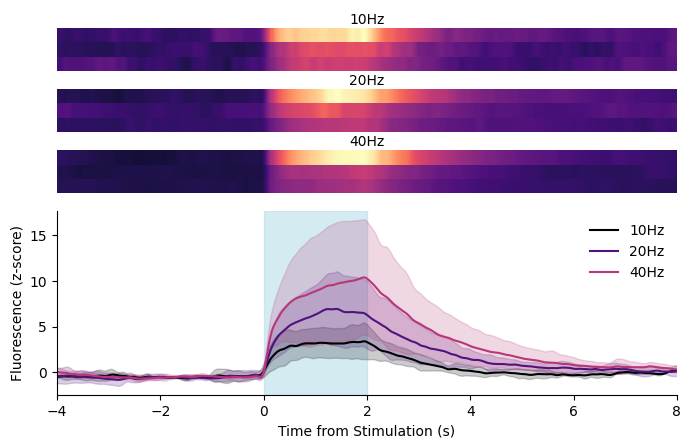

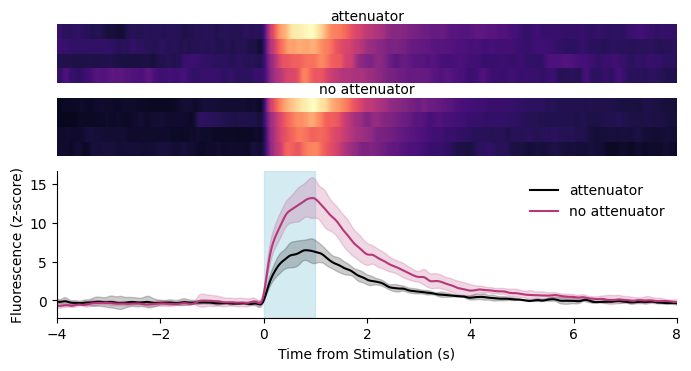

In [45]:
def extract_window_by_index(index, df, timestamps, window_size=500):
    if 0 <= index < len(timestamps):
        timestamp = timestamps[index]
        matched_indices = df.index[df['TimeStampAdjusted'] == timestamp].tolist()
        if matched_indices:
            closest_index = matched_indices[0]
            start_index = max(0, closest_index - window_size)
            end_index = min(len(df), closest_index + window_size)
            window_df = df.iloc[start_index:end_index].copy()
            window_df['RelativeIndex'] = range(-closest_index + start_index, end_index - closest_index)
            window_df['Event'] = index  # Add event identifier for heatmap plotting
            return window_df

def plotPSTH_with_heatmaps(df, *timestamps_lists, window_size=500, bar=None, legend_names=None, lineplot_colormap='rainbow_r', heatmap_colormap='viridis', download = True):
    num_heatmaps = len(timestamps_lists)
    plt.figure(figsize=(8, 2 + num_heatmaps))  # Adjust figure size based on the number of heatmaps and line plot height

    # Create a gridspec layout with less height for the line plot and reduced hspace
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.1)

    max_value, min_value = None, None  # Variables for consistent colormap scaling across heatmaps

    # Indices for -8 to 4 seconds range
    left_index, right_index = -4 * 50, 8 * 50

    for i, timestamps in enumerate(timestamps_lists):
        all_windows = pd.DataFrame()

        for index in range(len(timestamps)):
            window_df = extract_window_by_index(index, df, timestamps, window_size)
            if window_df is not None:
                all_windows = pd.concat([all_windows, window_df], ignore_index=True)

        heatmap_data = all_windows.pivot(index="Event", columns="RelativeIndex", values="Fluorescence_Corrected_Z")

        # Limit heatmap_data to the -8 to 4 seconds range
        heatmap_data = heatmap_data.loc[:, left_index:right_index]

        # Determine global min and max values for colormap scaling
        max_value, min_value = max(max_value, heatmap_data.max().max()) if max_value else heatmap_data.max().max(), min(min_value, heatmap_data.min().min()) if min_value else heatmap_data.min().min()

        # Create an inset axis for each heatmap
        heatmap_ax = plt.subplot(gs[0])
        inset_ax = heatmap_ax.inset_axes([0, 1-(i+1)/num_heatmaps, 1, 1/num_heatmaps-0.1])
        sns.heatmap(heatmap_data, cmap=heatmap_colormap, cbar=False, ax=inset_ax, vmax=max_value, vmin=min_value*2)
        inset_ax.set_title(legend_names[i] if legend_names and i < len(legend_names) else f'List {i + 1}', fontsize=10, pad=3)
        inset_ax.axis('off')  # Remove ticks, ticklabels, and spines
        heatmap_ax.axis('off')  # Remove ticks, ticklabels, and spines

    # Plot line plot below heatmaps
    ax2 = plt.subplot(gs[1])

    if bar:
        ax2.axvspan(bar[0], bar[1], color='lightblue', alpha=0.5)

    colors = plt.get_cmap(lineplot_colormap)(np.linspace(0, 0.5, num_heatmaps))

    for i, timestamps in enumerate(timestamps_lists):
        all_windows = pd.DataFrame()

        for index in range(len(timestamps)):
            window_df = extract_window_by_index(index, df, timestamps, window_size)
            if window_df is not None:
                all_windows = pd.concat([all_windows, window_df], ignore_index=True)

        mean_ci_df = all_windows.groupby('RelativeIndex')['Fluorescence_Corrected_Z'].agg(['mean', 'sem'])
        mean_ci_df['ci95_lo'] = mean_ci_df['mean'] - 1.96 * mean_ci_df['sem']
        mean_ci_df['ci95_hi'] = mean_ci_df['mean'] + 1.96 * mean_ci_df['sem']

        legend_label = legend_names[i] if legend_names and i < len(legend_names) else f'List {i + 1}'
        ax2.plot(mean_ci_df.index / 50, mean_ci_df['mean'], label=legend_label, color=colors[i], alpha=1)
        ax2.fill_between(mean_ci_df.index / 50, mean_ci_df['ci95_lo'], mean_ci_df['ci95_hi'], color=colors[i], alpha=0.2)

    sns.despine(ax=ax2)  # Remove spines
    ax2.set_xlabel('Time from Stimulation (s)')
    ax2.set_ylabel('Fluorescence (z-score)')
    ax2.set_xticks(np.arange(min(mean_ci_df.index / 50), max(mean_ci_df.index / 50) + 1, 2))  # Set x-axis ticks to every 2 seconds
    ax2.set_yticks(np.arange(0,20,5))  # Set y-axis ticks to every 2 seconds
    ax2.set_xlim(-4,8)
    ax2.legend(frameon=False)

    if (download):
      # Download the processed file
      new_filename = str(legend_names) + '_heatmap.pdf'
      plt.savefig(new_filename, format='pdf', bbox_inches = 'tight')
      print(f"Downloading '{new_filename}'...")
      files.download(new_filename)


# Example usage with three lists of timestamps and custom legend names
plotPSTH_with_heatmaps(df, timestamps_10Hz, timestamps_20Hz, timestamps_40Hz, bar=[0, 2], legend_names=['10Hz', '20Hz', '40Hz'], lineplot_colormap='magma', heatmap_colormap='magma', download = True)
plotPSTH_with_heatmaps(df, attenuator_1sec20Hz, noattenuator_1sec20Hz, bar=[0, 1], legend_names=['attenuator', 'no attenuator'], lineplot_colormap='magma', heatmap_colormap='magma', download = True)